In [14]:
# Automatically re-import files when updated
%load_ext autoreload
%autoreload 2  
%conda install pandas matplotlib
import time, json, pandas as pd, IPython, tensorflow as tf
# Load packages
from models import block, BATCH_SIZE
from utils import to_dataset, fgsm
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load models

In [15]:
# Load models
with tf.keras.utils.custom_object_scope({
    "block": block
    }):
    decoder = tf.keras.models.load_model("decoder.keras")
    encoder = tf.keras.models.load_model("encoder.keras")
    classifier = tf.keras.models.load_model("classifier.keras")

# Visualize results

True label: 5        
predicted label on original image: 5        
Predicted label on adversarial example: 5        
Predicted label on reconstructed image: 5


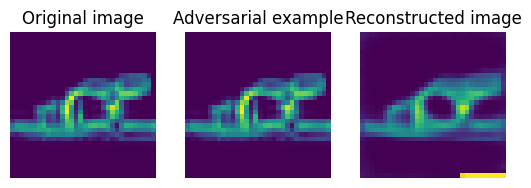

In [16]:
# Get data
_, (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Convert to tf dataset 
data_test = to_dataset(X_test, y_test)

# Split
imgs, labels = list(data_test.take(1))[0]
# For originals
original_predictions = classifier(imgs, training=False)
# For adversarials
adv_imgs = fgsm(classifier, imgs, 0.06)
adv_predictions = classifier(adv_imgs, training=False)
# For reconstructions
z = encoder(adv_imgs, training=False)
reconstructed = decoder(z, training=False)
predictions = classifier(reconstructed, training=False)

# Plot
for (img, orig_pred, adv_img, rec, label, pred, adv_pred) in zip(imgs, original_predictions, adv_imgs, reconstructed, labels, predictions, adv_predictions):
    # Clear display
    IPython.display.clear_output()
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    # Plot the original image
    ax1.imshow(img)
    ax1.set_title("Original image")
    ax1.axis("off")
    # Plot the original image
    ax2.imshow(adv_img)
    ax2.set_title("Adversarial example")
    ax2.axis("off")
    # Plot the reconstructed image
    ax3.imshow(rec)
    ax3.set_title("Reconstructed image")
    ax3.axis("off")
    # Add context
    print(f"True label: {tf.math.argmax(label).numpy()}\
        \npredicted label on original image: {tf.math.argmax(orig_pred).numpy()}\
        \nPredicted label on adversarial example: {tf.math.argmax(adv_pred).numpy()}\
        \nPredicted label on reconstructed image: {tf.math.argmax(pred).numpy()}")
    # Show for some time
    plt.show()
    time.sleep(2)

# Training progress

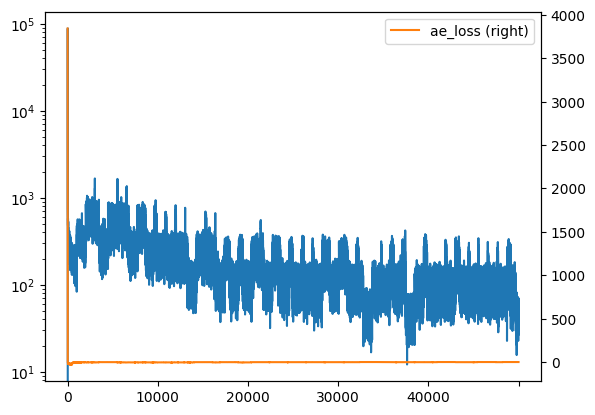

In [17]:
# Plot training progress
history = json.load(open("history.json", mode="r"))
history = pd.DataFrame.from_dict(history, orient="index")
plt.yscale("log");
history["classifier_loss"].plot();
history["ae_loss"].plot(secondary_y=True);
plt.legend();

# Plot models

In [ ]:
# Plot models (inception done manually)
tf.keras.utils.plot_model(encoder, show_layer_names=False, to_file="encoder.png");
block = block(1, 3, 1)
block.build((BATCH_SIZE, None, None, 3))
tf.keras.utils.plot_model(block, show_layer_names=False, to_file="downsampler.png");